# VAE for brainwave classification

In this notebook, we train a VAE using datasets taken from four subjects in three different states: neutral, concentrating, and relaxing. The raw datsets was obtained from https://github.com/jordan-bird/eeg-feature-generation/tree/master/dataset/original_data

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import normalize

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import to_categorical

!pip install pyyaml h5py
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data preprocessing

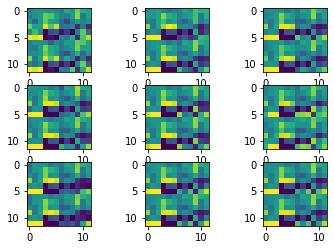

(1797, 12, 12, 1)


In [117]:
matrix_data = pd.read_csv('/content/gdrive/MyDrive/testFeat.csv', error_bad_lines=False)
labels = matrix_data['Label']
matrix = matrix_data.iloc[:,:-1]

min_max_scaler = preprocessing.MinMaxScaler()
matrix = min_max_scaler.fit_transform(matrix)
X_train, X_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, shuffle=True, random_state=8)

# Reshape each row as a 12 x 12 image
def reshape_to_12(data):
    new_arr = np.zeros((12,12))
    for i in range(data.shape[0]):
        if (i > 0):
            row_data = np.reshape(data[i,:], (12,12))
            new_arr = np.dstack((new_arr, row_data))
        else: 
            new_arr = np.reshape(data[0,:], (12,12))
    return new_arr
x_train = reshape_to_12(X_train)
x_test = reshape_to_12(X_test)

x_train = np.asarray(np.moveaxis(x_train, -1, 0)).astype('float32').round(decimals=4)
x_test = np.asarray(np.moveaxis(x_test, -1, 0)).astype('float32').round(decimals=4)
y_train = np.asarray(y_train).astype(np.int64).reshape((-1,1))
y_test = np.asarray(y_test).astype(np.int64).reshape((-1,1))

label_dict = {
 0: 'relaxed',
 1: 'neutral',
 2: 'concentrating'
}

# Checking min max within [0,1]
np.max(x_train), np.min(x_test)

# Plotting some images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_test[random.randrange(0, 450), :,:])
plt.show()

x_train = x_train.reshape(-1, 12, 12, 1)
x_test = x_test.reshape(-1, 12, 12, 1)
print(x_train.shape)

In [6]:
# Adapted from https://www.datacamp.com/community/tutorials/autoencoder-classifier-python

# Splitting the data for training and validation
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=10)

# Creating VAE

#### From https://keras.io/examples/generative/vae/

In [118]:
# Parameters
batch_size = 32
epochs = 800
num_classes = 3
latent_dim = 2
input_img = Input(shape = (12, 12, 1))

##### Create sampling layer

In [119]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

##### Building the encoder

In [120]:
encoder_inputs = keras.Input(shape=(12, 12, 1))
x = layers.Conv2D(32, 3, 
                  activation="relu", 
                  strides=2, 
                  padding="same")(encoder_inputs)
#x = BatchNormalization()(x)
x = layers.Conv2D(64, 3, 
                  activation="relu", 
                  strides=2, 
                  padding="same")(x)
#x = BatchNormalization()(x)      

# Latent space //bottleneck layer  
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 12, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 6, 6, 32)     320         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 3, 3, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 576)          0           conv2d_7[0][0]                   
____________________________________________________________________________________________

##### Building the decoder

In [121]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3 * 3 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((3, 3, 64))(x)
x = layers.Conv2DTranspose(64, 3, 
                           activation="relu", 
                           strides=2, 
                           padding="same")(x)
x = BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, 
                           activation="relu", 
                           strides=2, 
                           padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 576)               1728      
_________________________________________________________________
reshape_2 (Reshape)          (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 12, 12, 32)        18464     
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 32)        128 

##### Defining the VAE as a Model

In [122]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    #keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    keras.losses.mse(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #total_loss = reconstruction_loss + kl_loss
            total_loss = K.mean(reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Training the VAE

In [123]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))
vae.fit(x_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Epoch 1/800
57/57 [==============================] - 2s 18ms/step - loss: 280.4388 - reconstruction_loss: 223.5557 - kl_loss: 4.2347
Epoch 2/800
57/57 [==============================] - 1s 17ms/step - loss: 55.3814 - reconstruction_loss: 40.4786 - kl_loss: 8.0188
Epoch 3/800
57/57 [==============================] - 1s 17ms/step - loss: 40.5090 - reconstruction_loss: 35.4116 - kl_loss: 4.5730
Epoch 4/800
57/57 [==============================] - 1s 17ms/step - loss: 38.0271 - reconstruction_loss: 34.2962 - kl_loss: 3.3681
Epoch 5/800
57/57 [==============================] - 1s 18ms/step - loss: 36.1470 - reconstruction_loss: 33.1193 - kl_loss: 3.0824
Epoch 6/800
57/57 [==============================] - 1s 17ms/step - loss: 35.2339 - reconstruction_loss: 32.4411 - kl_loss: 2.7680
Epoch 7/800
57/57 [==============================] - 1s 18ms/step - loss: 36.2920 - reconstruction_loss: 31.7050 - kl_loss: 2.6733
Epoch 8/800
57/57 [==============================] - 1s 18ms/step - loss: 35.5731

# Results

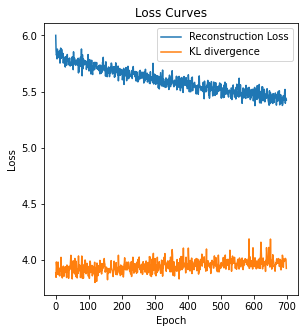

In [126]:
# Plotting the loss curves
plt.figure(figsize=[10,5])
plt.subplot(122)
plt.plot(vae_history.history['reconstruction_loss'])
plt.plot(vae_history.history['kl_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Reconstruction Loss','KL divergence'])
plt.title('Loss Curves')
plt.show()

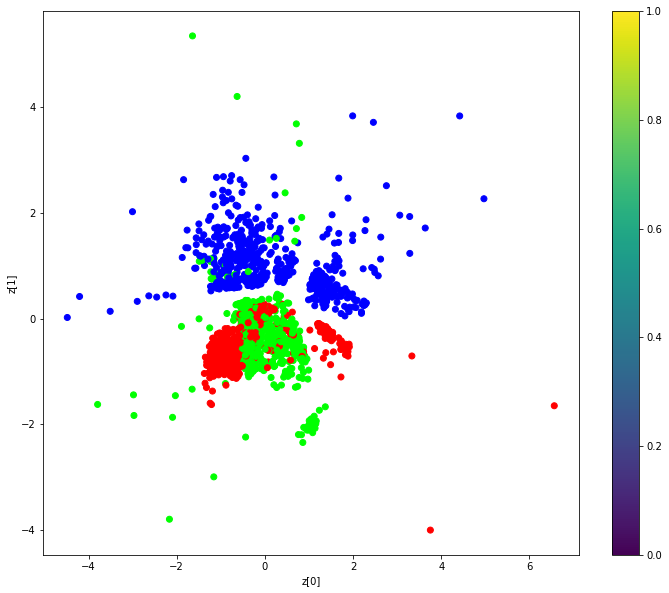

In [131]:
# One-hot encoding the labels
y_train_OH = to_categorical(y_train)
y_test_OH = to_categorical(y_test)

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_train, y_train_OH)

##### Saving the trained model

In [133]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model

# Take the latent vector from the first image in x_test since one images represents one time slice
vae.encoder.predict(x_test)
#vae.save('saved_model/trained_vae') 

[array([[ 1.50293088e+00, -1.00775719e+00],
        [-1.08780789e+00, -6.50419712e-01],
        [ 1.18098986e+00, -1.82452214e+00],
        [ 7.47731745e-01, -7.44390845e-01],
        [-5.37301719e-01,  1.47547960e+00],
        [ 9.87191677e-01, -2.18229151e+00],
        [ 3.84723663e-01,  1.24498665e+00],
        [-5.43221831e-02,  3.48301679e-01],
        [-8.74662846e-02,  2.04281241e-01],
        [-8.55578244e-01, -6.80029988e-01],
        [-4.75480676e-01, -2.17245519e-02],
        [-2.43288732e+00,  5.20766377e-01],
        [ 1.19583476e+00,  4.56648737e-01],
        [-3.35417032e-01,  1.19158030e+00],
        [ 1.02865410e+00,  5.06391764e-01],
        [-1.00530720e+00, -4.91071910e-01],
        [ 4.92095649e-01, -5.38657606e-02],
        [-8.61042917e-01, -2.25459188e-01],
        [ 4.41690803e-01,  9.07230377e-01],
        [-4.69661772e-01,  1.54388458e-01],
        [ 1.43517268e+00,  4.89082485e-01],
        [-2.29099140e-01,  2.06053048e-01],
        [-2.76369333e-01, -2.934

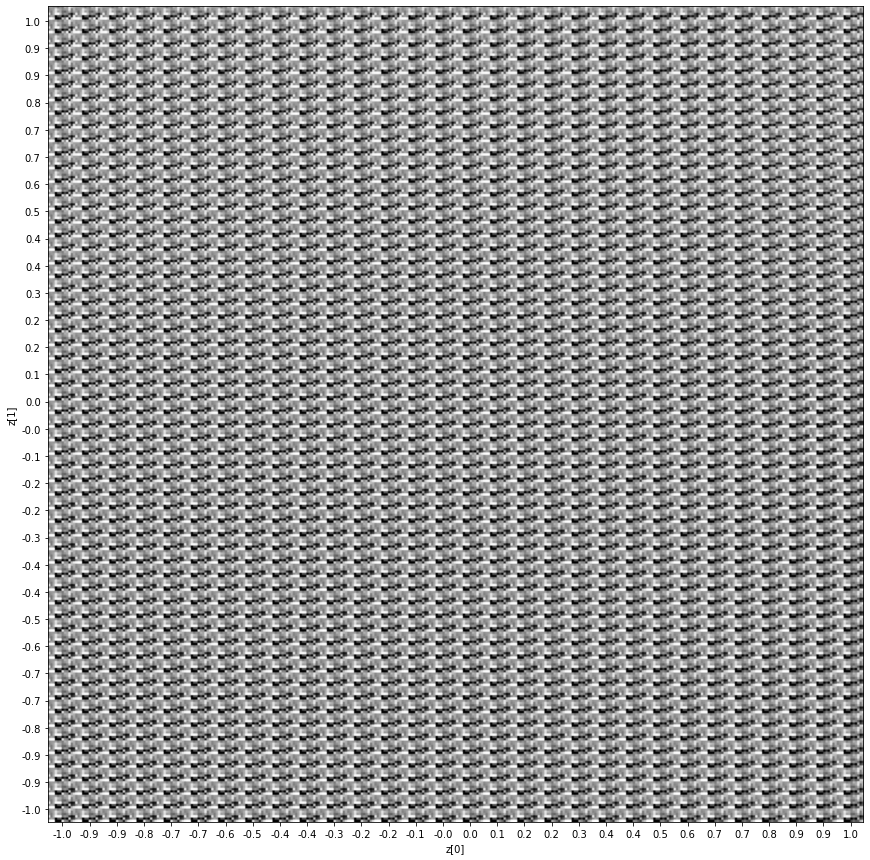

In [135]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold 
    feat_size = 12
    scale = 1.0
    figure = np.zeros((feat_size * n, feat_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(feat_size, feat_size)
            figure[
                i * feat_size : (i + 1) * feat_size,
                j * feat_size : (j + 1) * feat_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = feat_size // 2
    end_range = n * feat_size + start_range
    pixel_range = np.arange(start_range, end_range, feat_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

# Extract latent space representation (?


In [38]:
# Saving the weights
vae.save_weights('vae.w')

In [134]:
# Getting the weights of the model
#vae.get_weights()[0][1]

# Separating the encoder portion of the model
vae = Model(x_test, encoder)
#classifier = Dense(nb_classes, activation='softmax')(encoded)
#model = Model(input_img, classifier)

ValueError: ignored